The intent of this algorithm is to model the complex socio-economic factors considered by a judge when setting a defendant’s bail amount for pre-trial detention, and to produce a rigorous and math-based determination for what the dollar amount the bail should be set at. The importance of using an machine learning algorithm in these situations is because human judges are subject to human biases (whether they are intentional or latent) and can have an unintended and disastrous impact on the defendant. In this case an algorithm carefully designed to mitigate agains these biases will provide the optimal outcome.

The features of the model will reflect demographic information about the defendent, and the target variable to be predicted will be a class assigned to a numeric variable associated with the recommended dollar amount that bail should be set at.

#### Training data:
- ["Accused Pre-Trial Inmates in Correctional Facilities" dataset](https://data.ct.gov/Public-Safety/Accused-Pre-Trial-Inmates-in-Correctional-Faciliti/b674-jy6w)

In [1]:
%config InlineBackend.figure_format = 'retina'
import re
import requests
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn_transformers.classifier_helpers import FeatureSelector
from sklearn_transformers.classifier_helpers import MultiColumnLabelEncoder
from sklearn_transformers.classifier_helpers import BinaryClassifierWithNoise
import helpers.classifier_report as classifier_report

### Download data:

The availability of pre-trial detention data on the individual level is extremely limited, however, in order to create a model for individual use, training on individual-level data is necessary. Fortunately, the Connecticut Department of Corrections currently maintains an updated-daily and anonymized dataset that is sufficient for modeling according to the intent stated above, the ["Accused Pre-Trial Inmates in Correctional Facilities" dataset](https://data.ct.gov/Public-Safety/Accused-Pre-Trial-Inmates-in-Correctional-Faciliti/b674-jy6w).

In [2]:
bail_data_filename = 'data/bail_data.csv'
bail_data_url = 'https://data.ct.gov/api/views/b674-jy6w/rows.csv?accessType=DOWNLOAD'

response = requests.get(bail_data_url)
with open(bail_data_filename, 'wb') as out_file:
    out_file.write(response.content)

_df = pd.read_csv(bail_data_filename)
print(_df.shape)
_df.sample(5)

(4572123, 10)


,DOWNLOAD DATE,IDENTIFIER,LATEST ADMISSION DATE,RACE,GENDER,AGE,BOND AMOUNT,OFFENSE,FACILITY,DETAINER
1191475,08/14/2017,ZZSERLCR,06/27/2017,WHITE,M,27,25000,"LARCENY, FOURTH DEGREE AM",NEW HAVEN CC,NONE
883189,05/10/2017,ZZSEJEBH,02/08/2017,WHITE,M,23,130100,CRIM VIOL OF PROTECTIVE ORDER DF,HARTFORD CC,NONE
4381366,05/01/2020,ZZSHRZCZ,08/28/2019,HISPANIC,M,39,1500000,MANSLAUGHTER 2ND WITH MV (INTOX) CF,WALKER RC,NONE
638559,02/19/2017,ZZHLLSLW,01/18/2017,WHITE,M,55,50000,"FAILURE TO APPEAR, SECOND DEGREE AM",BRIDGEPORT CC,NONE
1538470,12/08/2017,ZZSZHJLZ,09/11/2017,WHITE,M,57,75000,VIOLATION OF PROBATION OR COND DISCHG,BRIDGEPORT CC,NONE


### Preprocess:

In [3]:
df = _df.copy()
df = df.rename(columns={column: column.strip().lower().replace(' ', '_') for column in df.columns})

In order to transform the raw data into a state prepared for modeling, a fair amount of preprocessing must occur. There are three predominant transformations: `extract_classes()`,  `determine_age_group()`, and `determine_bond_amount()`, as well as the cleanup and standarization of some columns.

The first transformation, `extract_classes()`, extracts and decodes the last two characters in the values within the `OFFENSE` column, these characters represent the 'offense class' and the 'crime class' respectively. By extracting these two values, we obtain a higher level categorical variable that the specific offense. This enables a more generalizable feature for our model instead of the specific value for the 'offense'. It also reduces dimensionality, making the values easier for a model to determine a pattern within the features.

In [4]:
class_pattern = re.compile('\s([A-Z]?)([A-Z])$')
df[['offense_class', 'crime_class']] = df['offense'].str.extract(class_pattern, expand=False)
df = df.fillna({'offense_class': 'unknown', 'crime_class': 'unknown'})
df.shape

(4572123, 12)

In [5]:
field_replacements = {
    'race': {
        'amer ind': 'native american',
    },
    'gender': {
        'm': 'male',
        'f': 'female',
    },
    'detainer': {
        'state of ct': 'state',
        'consec sent': 'consecutive sentence',
        'governor wrnt': 'governor warrant',
        'other state': 'state',
        'none': 'unknown',
        '': 'unknown',
    },
    'crime_class': {
        'F': 'felony',
        'M': 'misdemeanor',
        'C': 'unknown',
        'I': 'unknown',
    },
    'offense_class': {
        'A': 'a', 
        'B': 'b',  
        'C': 'c',
        'D': 'd',
        'U': 'unknown',
        '': 'unknown',
    }
}

df['crime_class'] = df['crime_class'].replace(field_replacements['crime_class'])
df['offense_class'] = df['offense_class'].replace(field_replacements['offense_class'])
df['race'] = df['race'].str.lower().replace(field_replacements['race'])
df['gender'] = df['gender'].str.lower().replace(field_replacements['gender'])
df['detainer'] = df['detainer'].str.lower().replace(field_replacements['detainer'])
print(df.shape)
df.sample(5)

(4572123, 12)


,download_date,identifier,latest_admission_date,race,gender,age,bond_amount,offense,facility,detainer,offense_class,crime_class
2756172,12/04/2018,ZZSZEWSL,11/05/2018,black,male,26,40000,INJURY OR RISK OF INJURY TO MINOR F,OSBORN CI,unknown,unknown,felony
3027276,02/20/2019,ZZSEZECE,12/03/2018,hispanic,male,25,230000,CRIMINAL POSSESSION OF A PISTOL DF,BRIDGEPORT CC,unknown,d,felony
198863,09/14/2016,ZZSELLRJ,08/29/2016,hispanic,male,34,250000,CRIM VIOL OF PROTECTIVE ORDER DF,HARTFORD CC,unknown,d,felony
1604725,12/28/2017,ZZRJLWRW,02/21/2017,black,male,36,175000,POSSESSION OF NARCOTICS,NEW HAVEN CC,unknown,unknown,unknown
1819843,03/04/2018,ZZRWLSHW,11/01/2017,hispanic,male,38,100050,EVADING RESPONSIBILITY M,HARTFORD CC,unknown,unknown,misdemeanor


Similarly, the next transformation, `determine_age_group()`, changes the ordinal value of the `age` column into a categorical variable, again to reduce dimensionality.

In [6]:
def determine_age_group(age):
    if age < 17:
        return '<17'
    elif 17 < age <= 24:
        return '18–24'
    elif 24 < age <= 34:
        return '25–34'
    elif 34 < age <= 44:
        return '35–44'
    elif 44 < age <= 54:
        return '45–54'
    elif 54 < age < 64:
        return '55–64'
    else:
        return '65+'

df['age_group'] = df.apply(lambda row: determine_age_group(row['age']), axis=1)
df.sample(5)

,download_date,identifier,latest_admission_date,race,gender,age,bond_amount,offense,facility,detainer,offense_class,crime_class,age_group
4154165,02/12/2020,ZZSRZCHJ,05/23/2017,hispanic,male,33,250000,"SEXUAL ASSAULT, FIRST DEGREE F",CORRIGAN CI,unknown,unknown,felony,25–34
3705315,09/19/2019,ZZSHEJBW,08/21/2019,hispanic,male,18,35050,"BURGLARY, SECOND DEGREE CF",MANSON YI,unknown,c,felony,18–24
3746095,10/01/2019,ZZRWCJRC,01/16/2019,black,male,41,750000,MURDER AF,WALKER RC,unknown,a,felony,35–44
17326,07/24/2016,ZZELBBJZ,05/09/2016,black,male,53,500000,"ASSAULT, SECOND DEGREE DF",NORTHERN CI,unknown,d,felony,45–54
117765,08/06/2016,ZZHSBLBE,05/23/2011,black,male,25,1527000,HOME INVASION AF,BRIDGEPORT CC,special parole,a,felony,25–34


The last transformation is the most important because it enables this model to be a 'fair' and 'common sense' algorithm. Do to the history of structural racism inherent in the criminal justice system, the features present in the training data are considered to be highly biased against the victims of this oppression, and any fair model needs to account for this. Operating with the understanding that data is always biased, that un-biased data is a logically impossible and a naive ideal, the task here isn't to remove the bias, but shift its impact from the people whose lives have be negatively impacted by bail and onto the bail system itself. The setting of bail amount is an occasion for structural racism to occur. This can easily be addressed by transforming the value of the bail amount. The transformation, `determine_bond_amount()`, does this by turning the `bail amount`  from continuous variable (any dollar amount) into a binary categorical variable (one of two dollar amounts: `0.00` or `1.00`). The categories were chosen as representative of the original spirit of the [8th amendment](https://en.wikipedia.org/wiki/Eighth_Amendment_to_the_United_States_Constitution), where the two classes inherently prevent the model from inadvertanly producing an 'excessive' bail amount recommendation.

This value will be used as the dependent variable (label) for classification. 

In [7]:
def determine_bond_amount(series):
    return np.where(series > 2000000, '1.00', '0.00')

df['bond_amount'] = determine_bond_amount(df['bond_amount'])
df.sample(5)

,download_date,identifier,latest_admission_date,race,gender,age,bond_amount,offense,facility,detainer,offense_class,crime_class,age_group
530829,01/17/2017,ZZHRLEHE,05/02/2016,black,male,31,0.00,VIOLATION OF PROBATION OR COND DISCHG,HARTFORD CC,unknown,unknown,unknown,25–34
3845531,11/01/2019,ZZRJLSJZ,10/10/2019,black,male,36,0.00,VIOLATION OF PROBATION OR COND DISCHG,GARNER,unknown,unknown,unknown,35–44
156393,08/17/2016,ZZSELEHB,07/29/2016,hispanic,female,33,0.00,PROSTITUTION AM,YORK CI,unknown,a,misdemeanor,25–34
2930492,01/23/2019,ZZRBZWSZ,08/23/2018,hispanic,male,54,0.00,"SEXUAL ASSAULT, FOURTH DEGREE AM",CORRIGAN CI,unknown,a,misdemeanor,45–54
437078,12/20/2016,ZZHBHHRB,11/17/2015,black,male,21,0.00,"ASSAULT, SECOND DEGREE DF",HARTFORD CC,unknown,d,felony,18–24


Finally, the cleanup and standardization mapping expands the values of abbreviated input data (`f`→`female`, `consec sent`→`consecutive sentence`) and corrects the exonym `AMER IND` ('american indian'), opting for `native american` instead. 

One thing to note is that the ethnic category `HISPANIC` remains in the race category because there is not enough information in the data to disambiguate ethnicity from race. It is worth mentioning the decision to retain racial/ethnic information as features in this model at all. There are countless opportunities for mis-categorization of race, from the prespective of the individual imputting the data (we have no clear way of reliably knowing that every instance within the data was reported by the individual the data represents or not) to the unnecessary reduction of diverse and complicated family heritage into brittle and outdated categories. However, the intent of the model is to diminish the impact of these racial features, and the only way demonstrate that these features do not impact the recommendations is to include them as feature in the model.

### Model:

In [8]:
feature_columns = ['crime_class', 'offense_class', 'age_group', 'race', 'gender', 'detainer']
target_column = 'bond_amount'

x = df.copy()[feature_columns]
y = df.copy()[target_column]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

print(len(x_train), len(x_test))

3657698 914425


In [9]:
model = Pipeline([
    ('feature_column_encoder', MultiColumnLabelEncoder(columns=feature_columns)),
    ('classifier', BinaryClassifierWithNoise(
        RandomForestClassifier(
            n_estimators=10,
            n_jobs=1,
            random_state=1337,
        )
    )),
])
model.fit(x_train, y_train)

Pipeline(steps=[('feature_column_encoder', <sklearn_transformers.classifier_helpers.MultiColumnLabelEncoder object at 0x7f95c8022208>), ('classifier', BinaryClassifierWithNoise(classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='aut...mators=10, n_jobs=1, oob_score=False, random_state=1337,
            verbose=0, warm_start=False)))])

Accuracy:  0.987956
Recall:    0.999836
F-beta:    0.993939
Precision: 0.988111

----------------------------------------
Feature Importances:
crime_class=misdemeanor       0.333207
crime_class=felony            0.256596
crime_class=unknown           0.191440
offense_class=c               0.112013
offense_class=a               0.086826
offense_class=b               0.019918


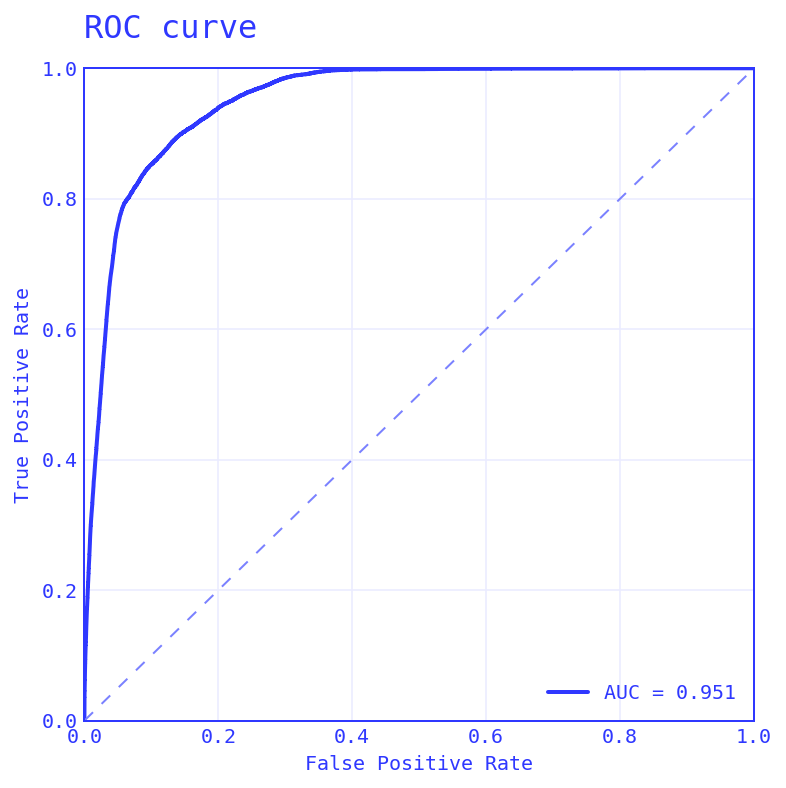

[{'0.00': 0.99943522035904442, '1.00': 0.00056477964095558164},
 {'0.00': 0.88664721592895601, '1.00': 0.11335278407104399},
 {'0.00': 0.9995901015570815, '1.00': 0.00040989844291849931},
 {'0.00': 0.99988266355152688, '1.00': 0.00011733644847311542},
 {'0.00': 0.99919976145037281, '1.00': 0.00080023854962718577}]

In [10]:
classifier_report.performance(model, x_test, y_test, encoder_step_label='feature_column_encoder', cross_validate=False)
classifier_report.roc_curve(model, x_test, y_test)
display(model.predict_proba(x_test.sample(5)))

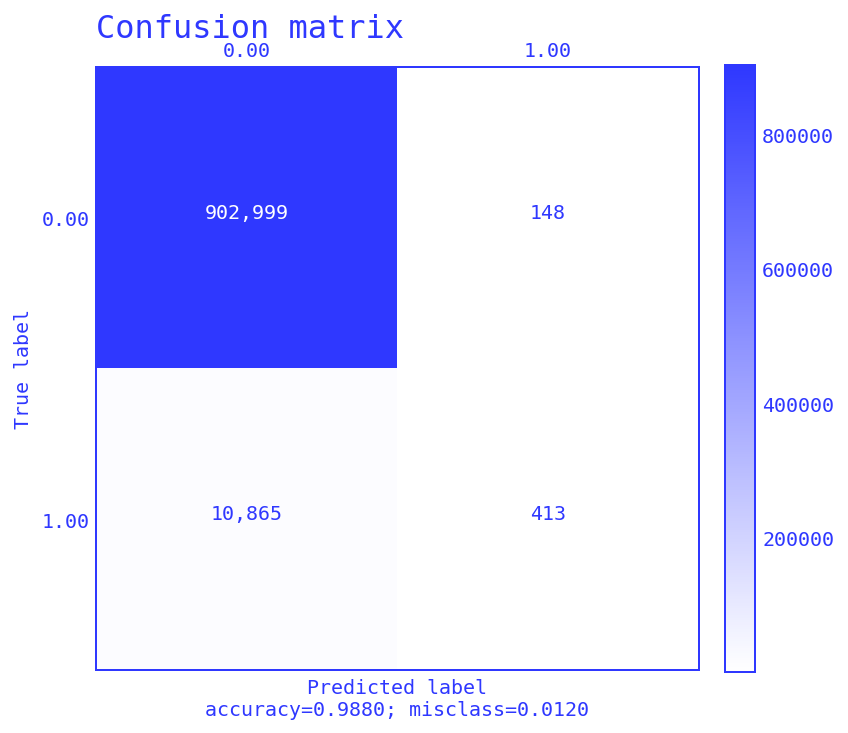

In [11]:
y_pred = model.predict(x_test)
class_names = model.named_steps['classifier'].classifier.classes_
classifier_report.plot_confusion_matrix(y_test, y_pred, class_names=class_names)